In [1]:
!pip -q install --upgrade torch torchvision

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 102.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 18.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 5.3 MB/s eta 0:00:00:00:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━

In [2]:
import os

CELEBA_DIR = "/kaggle/input/50k-celeba-dataset-64x64/50k"

# Quick check: show how many images are inside
print("Files found:", len(os.listdir(CELEBA_DIR)))

Files found: 50000


In [3]:
import glob
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

IMG_SIZE   = 64
Z_DIM      = 128
G_CH, D_CH = 64, 64
BATCH_SIZE = 128
EPOCHS     = 1   # start with 1 for test run
LR, BETA1, BETA2 = 2e-4, 0.5, 0.999

SAMPLES_DIR = "/kaggle/working/samples"
ART_DIR     = "/kaggle/working/art_faces"
os.makedirs(SAMPLES_DIR, exist_ok=True)
os.makedirs(ART_DIR, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class CelebADataset(Dataset):
    def __init__(self, root, transform=None):
        self.paths = sorted(glob.glob(str(Path(root) / "*.jpg")))
        self.t = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.t(img) if self.t else img

ds = CelebADataset(CELEBA_DIR, transform)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print("Dataset ready, total images:", len(ds))


Dataset ready, total images: 50000


In [4]:
import torch.nn as nn
from torchvision import utils

# Generator
class Generator(nn.Module):
    def __init__(self, zdim=128, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(zdim, ch*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ch*8), nn.ReLU(True),
            nn.ConvTranspose2d(ch*8, ch*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ch*4), nn.ReLU(True),
            nn.ConvTranspose2d(ch*4, ch*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ch*2), nn.ReLU(True),
            nn.ConvTranspose2d(ch*2, ch, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ch), nn.ReLU(True),
            nn.ConvTranspose2d(ch, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z): return self.net(z)

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ch, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch, ch*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch*2, ch*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ch*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch*4, ch*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ch*8), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch*8, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x): return self.net(x).view(-1)# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, ch, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch, ch*2, 4, 2, 1, bias=False), nn.BatchNorm2d(ch*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch*2, ch*4, 4, 2, 1, bias=False), nn.BatchNorm2d(ch*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch*4, ch*8, 4, 2, 1, bias=False), nn.BatchNorm2d(ch*8), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ch*8, 1, 4, 1, 0, bias=False)
        )
    def forward(self, x): return self.net(x).view(-1)

In [6]:
# Initialize
Z_DIM = 128
G, D = Generator(Z_DIM).to(device), Discriminator().to(device)

# Optimizers & loss
optG = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCEWithLogitsLoss()

fixed_z = torch.randn(64, Z_DIM, 1, 1, device=device)

def save_grid(tensor, path, nrow=8):
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, value_range=(-1,1))
    utils.save_image(grid, path)

print("Models initialized on:", device)

Models initialized on: cuda


In [7]:
import os

EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    for i, real in enumerate(dl):
        real = real.to(device)
        bs = real.size(0)

        # Train Discriminator
        z = torch.randn(bs, Z_DIM, 1, 1, device=device)
        fake = G(z).detach()
        lossD = criterion(D(real), torch.ones(bs, device=device)) + \
                criterion(D(fake), torch.zeros(bs, device=device))
        optD.zero_grad(); lossD.backward(); optD.step()

        # Train Generator
        z = torch.randn(bs, Z_DIM, 1, 1, device=device)
        lossG = criterion(D(G(z)), torch.ones(bs, device=device))
        optG.zero_grad(); lossG.backward(); optG.step()

        if (i + 1) % 200 == 0:
            print(f"Epoch {epoch} [{i+1}/{len(dl)}] D={lossD.item():.3f} G={lossG.item():.3f}")

    with torch.no_grad():
        sample = G(fixed_z).cpu()
    save_grid(sample, f"{SAMPLES_DIR}/faces_epoch_{epoch:02d}.png")
    print(f"Saved samples to {SAMPLES_DIR}")

Epoch 1 [200/391] D=0.532 G=3.012
Saved samples to /kaggle/working/samples
Epoch 2 [200/391] D=0.428 G=3.262
Saved samples to /kaggle/working/samples
Epoch 3 [200/391] D=0.512 G=2.088
Saved samples to /kaggle/working/samples
Epoch 4 [200/391] D=2.576 G=2.140
Saved samples to /kaggle/working/samples
Epoch 5 [200/391] D=0.264 G=4.036
Saved samples to /kaggle/working/samples
Epoch 6 [200/391] D=0.458 G=6.488
Saved samples to /kaggle/working/samples
Epoch 7 [200/391] D=0.468 G=5.486
Saved samples to /kaggle/working/samples
Epoch 8 [200/391] D=0.330 G=3.764
Saved samples to /kaggle/working/samples
Epoch 9 [200/391] D=0.165 G=3.721
Saved samples to /kaggle/working/samples
Epoch 10 [200/391] D=0.189 G=3.938
Saved samples to /kaggle/working/samples


In [8]:
import torch

def slerp(val, low, high):
    """Spherical linear interpolation between two vectors."""
    low_norm = low / (low.norm(dim=1, keepdim=True) + 1e-8)
    high_norm = high / (high.norm(dim=1, keepdim=True) + 1e-8)
    dot = (low_norm * high_norm).sum(1, keepdim=True).clamp(-1 + 1e-7, 1 - 1e-7)
    omega = torch.acos(dot)
    so = torch.sin(omega)
    return (torch.sin((1.0 - val) * omega) / so) * low + (torch.sin(val * omega) / so) * high

# Generate interpolation
z1 = torch.randn(1, Z_DIM, device=device)
z2 = torch.randn(1, Z_DIM, device=device)

frames = []
for t in torch.linspace(0, 1, 16, device=device):
    zt = slerp(torch.tensor([t], device=device).view(-1, 1), z1, z2)
    img = G(zt.view(1, Z_DIM, 1, 1)).cpu()
    frames.append(img)

# Save as a horizontal strip
save_grid(torch.cat(frames), f"{ART_DIR}/interpolation_strip.png", nrow=16)
print("Saved artwork:", f"{ART_DIR}/interpolation_strip.png")


Saved artwork: /kaggle/working/art_faces/interpolation_strip.png


In [9]:
with torch.no_grad():
    # Create random latent batch
    Z = torch.randn(1024, Z_DIM, device=device)
    Zc = Z - Z.mean(0, keepdim=True)

    # Find top principal direction
    _, _, Vh = torch.linalg.svd(Zc, full_matrices=False)
    pc1 = Vh[0]

vals = torch.linspace(-2.5, 2.5, 11, device=device)
base = torch.randn(1, Z_DIM, device=device)
imgs = [G((base + a * pc1).view(1, Z_DIM, 1, 1)).cpu() for a in vals]

save_grid(torch.cat(imgs), f"{ART_DIR}/pca_walk_strip.png", nrow=len(vals))
print("Saved artwork:", f"{ART_DIR}/pca_walk_strip.png")


Saved artwork: /kaggle/working/art_faces/pca_walk_strip.png


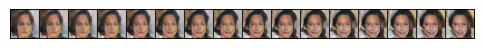

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img_path = "/kaggle/working/art_faces/interpolation_strip.png"

img = mpimg.imread(img_path)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()
